## Create microscopy labels for dataset

In [1]:
# Reference to ../src
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import csv
import os

## 1. Create labels file
Create a csv file with an id, figure name, modality (e.g. DMEL), set (train/validation) and image path to feed a Dataset class.

In [2]:
BASE_URL = '/mnt'
OUTPUT_PATH = '../labels/microscopy.csv'

In [22]:
with open(OUTPUT_PATH, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'NAME', 'MODALITY', 'SET', 'PATH'])
    i = 1
    
    for images_group in ('train', 'validation'):
        images_group_dir = '{0}/{1}'.format(BASE_URL, images_group)
        for microscopy_label in os.listdir(images_group_dir):
            microscopy_class_dir = '{0}/{1}'.format(images_group_dir, microscopy_label)
            for image_name in os.listdir(microscopy_class_dir):
                img_path = '{0}/{1}'.format(microscopy_class_dir, image_name)
                row = [i, image_name, microscopy_label, images_group, img_path]
                writer.writerow(row)
                i += 1

In [23]:
df = pd.read_csv(OUTPUT_PATH)
df.head()

,ID,NAME,MODALITY,SET,PATH
0,1,1423-0127-16-7-1-2.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-2.jpg
1,2,1423-0127-16-7-1-4.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-4.jpg
2,3,1423-0127-16-7-1-5.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-5.jpg
3,4,1423-0127-16-7-1-6.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-6.jpg
4,5,1423-0127-16-88-1-1.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-88-1-1.jpg


<AxesSubplot:xlabel='MODALITY'>

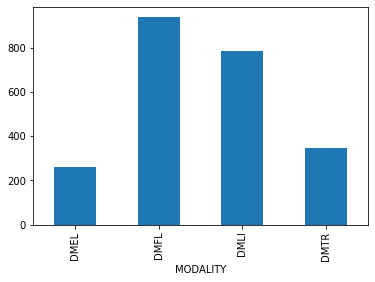

In [26]:
df.groupby(['MODALITY'])['ID'].count().plot.bar()

## 2. Get normalization values

In [3]:
#!pip install scikit-image
from dataset.MicroscopyDataset import MicroscopyDataset
from utils.calc_mean import calc_dataset_mean_std
from torchvision import transforms

In [4]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
transform = transforms.Compose(transform_list)

train_dataset = MicroscopyDataset(OUTPUT_PATH, 'train', transform=transform)
validation_dataset = MicroscopyDataset(OUTPUT_PATH, 'validation', transform=transform)

In [5]:
len(train_dataset), len(validation_dataset)

(1862, 468)

In [6]:
from torch.utils.data import DataLoader
loader = DataLoader(train_dataset, batch_size=4, num_workers=1, shuffle=False)

In [9]:
mean, std = calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=1)

In [10]:
mean

tensor([0.4857, 0.4740, 0.4755])

In [11]:
std

tensor([0.3648, 0.3557, 0.3669])

In [12]:
from dataset.MicroscopyTrainDataLoader import MicroscopyTrainDataLoader
loader = MicroscopyTrainDataLoader(OUTPUT_PATH)

In [13]:
train = loader.get_train_dataset()

In [14]:
train[0]

(tensor([[[1.4098, 1.2916, 1.3776,  ..., 1.3883, 1.4098, 1.4098],
          [1.3991, 1.3883, 1.2701,  ..., 1.3991, 1.4098, 1.4098],
          [1.3561, 1.1841, 0.2381,  ..., 1.3453, 1.3883, 1.3883],
          ...,
          [1.3668, 1.3561, 1.3561,  ..., 1.3991, 1.3776, 1.3776],
          [1.3991, 1.3023, 1.3776,  ..., 1.4098, 1.3991, 1.3991],
          [1.4098, 1.3346, 1.3883,  ..., 1.4098, 1.3991, 1.3991]],
 
         [[1.4788, 1.3575, 1.4457,  ..., 1.4567, 1.4788, 1.4788],
          [1.4677, 1.4567, 1.3355,  ..., 1.4677, 1.4788, 1.4788],
          [1.4236, 1.2473, 0.2771,  ..., 1.4126, 1.4567, 1.4567],
          ...,
          [1.4347, 1.4236, 1.4236,  ..., 1.4677, 1.4457, 1.4457],
          [1.4677, 1.3685, 1.4457,  ..., 1.4788, 1.4677, 1.4677],
          [1.4788, 1.4016, 1.4567,  ..., 1.4788, 1.4677, 1.4677]],
 
         [[1.4295, 1.3120, 1.3975,  ..., 1.4082, 1.4295, 1.4295],
          [1.4189, 1.4082, 1.2906,  ..., 1.4189, 1.4295, 1.4295],
          [1.3761, 1.2051, 0.2645,  ...,

In [17]:
from torchvision import models
from torch import nn

In [18]:
model = models.resnet50(pretrained=False)
# Reset the last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
model.layer1[0]

Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [24]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0183,  0.0163,  0.0014,  ..., -0.0250, -0.0139,  0.0119],
          [-0.0181, -0.0074, -0.0268,  ...,  0.0480, -0.0159,  0.0140],
          [ 0.0265,  0.0215, -0.0230,  ..., -0.0073, -0.0153, -0.0324],
          ...,
          [ 0.0217,  0.0164,  0.0248,  ..., -0.0144, -0.0322,  0.0233],
          [-0.0331,  0.0220, -0.0222,  ..., -0.0047,  0.0139,  0.0344],
          [-0.0059,  0.0039,  0.0014,  ..., -0.0082, -0.0206,  0.0248]],

         [[-0.0298,  0.0252, -0.0150,  ...,  0.0202,  0.0147, -0.0222],
          [-0.0180,  0.0001,  0.0052,  ...,  0.0057, -0.0016,  0.0235],
          [-0.0013, -0.0147,  0.0352,  ...,  0.0259, -0.0108,  0.0094],
          ...,
          [ 0.0399,  0.0062,  0.0230,  ..., -0.0412,  0.0114, -0.0574],
          [-0.0126, -0.0043,  0.0571,  ..., -0.0224, -0.0040, -0.0127],
          [-0.0351,  0.0275,  0.0023,  ...,  0.0126, -0.0196,  0.0107]],

         [[-0.0077,  0.0254,  0.0236,  ...,  0.0085,  0.0169,  0.0004],
        

Parameter containing:
tensor([[[[ 0.1033]],

         [[ 0.0703]],

         [[ 0.0853]],

         ...,

         [[ 0.0554]],

         [[ 0.1096]],

         [[ 0.0518]]],


        [[[ 0.0430]],

         [[-0.1319]],

         [[-0.1644]],

         ...,

         [[-0.0376]],

         [[-0.0132]],

         [[ 0.0806]]],


        [[[ 0.0085]],

         [[-0.0776]],

         [[ 0.0271]],

         ...,

         [[-0.1424]],

         [[-0.0688]],

         [[ 0.0110]]],


        ...,


        [[[-0.1353]],

         [[-0.0212]],

         [[ 0.0331]],

         ...,

         [[-0.0320]],

         [[ 0.0326]],

         [[ 0.0260]]],


        [[[ 0.2518]],

         [[-0.1309]],

         [[-0.0339]],

         ...,

         [[ 0.0779]],

         [[ 0.0662]],

         [[ 0.0502]]],


        [[[ 0.0440]],

         [[-0.1107]],

         [[ 0.1587]],

         ...,

         [[ 0.0752]],

         [[-0.0406]],

         [[ 0.1578]]]], requires_grad=True)
Parameter cont

In [31]:
model.layer1[0].conv1.requires_grad()

AttributeError: 'Conv2d' object has no attribute 'requires_grad'

In [39]:
for i, child in enumerate(model.children()):
    print(i)
    print(child)
    if i < 8:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True

0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2
ReLU(inplace=True)
3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [41]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [46]:
for p in model.fc.parameters():
    print(p.requires_grad)

True
True


In [51]:
# model.layer1
for p in model.layer1.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [52]:
model2 = models.resnet34(pretrained=False)
# Reset the last layer
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 4)

In [53]:
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
model3 = models.resnet101(pretrained=False)
# Reset the last layer
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, 4)

In [55]:
print(model3)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 